<a href="https://colab.research.google.com/github/tibernard/AI/blob/master/Minesweeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment and Two solvers

Cell (0, 2) Action: random choice
Cell (2, 0) Action: crossed
Cell (3, 1) Action: safe move
Cell (1, 0) Action: crossed
Cell (0, 0) Action: safe move
Cell (3, 3) Action: random choice
Cell (3, 2) Action: crossed
Cell (3, 0) Action: safe move
Cell (3, 3) Action: safe move


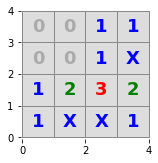

In [0]:
import numpy as np
import copy
from itertools import product
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from collections import deque


class MineSweeper(object):
    covered_color = '#DDDDDD'
    uncovered_color = '#AAAAAA'
    edge_color = '#888888'
    count_colors = ['#AAAAAA', 'blue', 'green', 'red', 'darkblue',
                    'darkred', 'darkgreen', 'black', 'black']
    flag_vertices = np.array([[0.25, 0.2], [0.25, 0.8],
                              [0.75, 0.65], [0.25, 0.5]])


      
         
      
    def __init__(self, width, height, nmines,agent):
        self.width, self.height, self.nmines,self.agent = width, height, nmines,agent

        # Create the figure and axes
        self.fig = plt.figure(figsize=((width + 2) / 3., (height + 2) / 3.))
        
        
        
        self.ax = self.fig.add_axes((0.05, 0.05, 0.9, 0.9),
                                    aspect='equal', frameon=False,
                                    xlim=(-0.05, width + 0.05),
                                    ylim=(-0.05, height + 0.05))

        # Create the grid of squares
        self.squares = np.array([[RegularPolygon((i + 0.5, j + 0.5),
                                                 numVertices=4,
                                                 radius=0.5 * np.sqrt(2),
                                                 orientation=np.pi / 4,
                                                 ec=self.edge_color,
                                                 fc=self.covered_color)
                                  for j in range(height)]
                                 for i in range(width)])
        [self.ax.add_patch(sq) for sq in self.squares.flat]
        
        # define internal state variables
        
        
        
        
        self.mines = None
        self.clear = None
        self.counts = None
        self.visited = np.zeros((self.width, self.height), dtype=bool)
        self.is_uncovered = np.zeros((self.width, self.height), dtype=bool)
        self.flags = np.zeros((self.width, self.height), dtype=object)
        self.mines = np.zeros((self.width, self.height), dtype=object)
        
        self.clear = np.zeros((self.width, self.height), dtype=object)
        self.counts = np.zeros((self.width, self.height), dtype=object)
        self.game_over = False
        
         #csp variables
        self.global_constraint = list()
        self.Old_global_constraint = list()
        
        self.Old_global_constraint2 = list()
        self.density=0.3
        
        
        op=[]

        for x in range(self.width):
          for y in range(self.height):
            op.append((x,y))
            
        if self.nmines>self.height*self.width:
          self.nmines=self.height*self.width
        for x in range(self.nmines):
          a = np.arange(len(op))
          np.random.shuffle(a)
          i,j= op[a[0]]
          self.mines[i][j]=True
          op.remove(op[a[0]])
          
        for i in range(self.width):
          for j in range(self.height):
            for n in range(-1,2):
              for r in range(-1,2):
                if r==0 and n==0: continue
                if (i+n==-1 or j+r==-1) or (i+n>self.width-1 or j+r>self.height-1): continue
               
               
                if self.mines[i+n][j+r]:
                  self.counts[i][j]=self.counts[i][j]+1
                  
                 
              
              
        #self.reveal_all()
    def reveal_all(self):
      for i in range(self.width):
          for j in range(self.height):
              self.reveal(i,j)
      
    def ifnull(self,var, val):
      if var is None:
        return val
      return var
    
    #This function return randomly a covered cell
    def random_covered_cell(self):
    
      op=[]
      for x in range(self.width):
        for y in range(self.height):
          if self.is_uncovered[x][y]==False and self.flags[x][y]==False:
            op.append((x,y))
      a = np.arange(len(op))
      np.random.shuffle(a)
      
      return op[a[0]]

      
    #Function that updates uncover variable to True reveal the numbers or the circle which is the mine
    def reveal(self,i,j):
      if self.is_uncovered[i][j]==False and self.flags[i][j]==False :
        
        if self.mines[i][j]==False:
              self.ax.text(i + 0.5, j + 0.5, str(self.ifnull(self.counts[i, j],0)),
                         color=self.count_colors[self.counts[i, j]],
                         ha='center', va='center', fontsize=18,
                         fontweight='bold')
        else:
          self.ax.add_patch(plt.Circle((i + 0.5, j + 0.5), radius=0.25,ec='black', fc='black'))
      self.is_uncovered[i][j]=True
     #Clsick plays two roles, itsimply reveal the cell, and recursively click on other cells the cell hitted is a zero
    #Finally if we hit a mines we reveal all the cell and we update the game over variable to true
    def click(self,i,j):
      self.reveal(i,j)
      self.visited[i][j]=True
      
      if self.counts[i][j]==0:
        for n in range(-1,2):
              for r in range(-1,2):
                if r==0 and n==0: continue
                if (i+n==-1 or j+r==-1) or (i+n>self.width-1 or j+r>self.height-1): continue
                if self.visited[i+n][j+r]==False:
                  self.click(i+n,j+r)
                  
      #self.reveal_all()            
      if self.mines[i][j]==True:
        self.game_over=True
        self.reveal_all()
        
    def flag(self,i,j):
      self.flags[i][j]=True
      self.ax.text(i + 0.5, j + 0.5, str("X"),
                 color=self.count_colors[1],
                 ha='center', va='center', fontsize=18,
                 fontweight='bold')
      

      

#This function return the number of cells that are not visisted yet
    def remain_visited(self):
      r_visisted = 0
      for i in range(self.width):
          for j in range(self.height):
            if self.is_uncovered[i][j]==False and self.flags[i][j]==False:
              r_visisted=r_visisted+1
      return r_visisted
    #This function return the number of mines flagged from the 8 surrounding cell
    def mine_cues(self,i,j):
      mine_cues_cnt=0
      for n in range(-1,2):
        for r in range(-1,2):
          if r==0 and n==0: continue
          if (i+n==-1 or j+r==-1) or (i+n>self.width-1 or j+r>self.height-1): continue
          if self.flags[i+n][j+r]==True:
            mine_cues_cnt=mine_cues_cnt+1
      return mine_cues_cnt
    
    def hidden_neighbors(self,i,j):
      hidden_=0
      for n in range(-1,2):
        for r in range(-1,2):
          if r==0 and n==0: continue
          if (i+n==-1 or j+r==-1) or (i+n>self.width-1 or j+r>self.height-1): continue
          if self.is_uncovered[i+n][j+r]==False  and self.flags[i+n][j+r]==False:
            hidden_=hidden_+1
      return hidden_
    
    
                  
      
      
    def add_new_constraints(self, constraint_list, new_constraints):
      known_mines = set()
      safe_moves = set()
      new_constraints = deque(new_constraints)
      while new_constraints:
        constraint_vars, constraint_val = new_constraints.popleft()
        delete_set = set()
        for i, constraint in enumerate(constraint_list):
          
          #Removing all constraint that summup to zero that means all arround 8 cells are either flagged or safe
          if constraint_val == 0:
            constraint[0] -= constraint_vars
            
            #If the value revealed is equal to the number of surrounding unrevealed cells that means all are mines
           
          elif len(constraint_vars) == constraint_val:
            constraint[1] -= len(constraint[0].intersection(constraint_vars))
            constraint[0] -= constraint_vars
          else:
              #If the new constraint is part to the of the contraints in the global constriant 
              # or a superset of the one of the global euations  We removed the subset
            if constraint[0].issuperset(constraint_vars):
              constraint[0] -= constraint_vars
              constraint[1] -= constraint_val
            elif constraint[0].issubset(constraint_vars):
              new_vars = constraint_vars.difference(constraint[0])
              new_val = constraint_val - constraint[1]
              new_constraints.append([new_vars, new_val])
              continue 
          #Avoid addint empty constraint to the list
          if not constraint[0]:
            delete_set.add(i) 

          # When constraint is resolved and valid we add it to the list of new vaid constraint
          # We check the soltion of the equations for safe cells and safe mines to be returned by the functin
          if constraint[1] == 0:
            new_constraints.append(constraint)
            safe_moves = safe_moves.union(constraint[0])
            delete_set.add(i)
          elif len(constraint[0]) == constraint[1]:
            new_constraints.append(constraint)
            known_mines = known_mines.union(constraint[0])
            delete_set.add(i)
        #Delete all the unecessary constraints added to delete_set
        for i in sorted(delete_set, reverse=True):
          del constraint_list[i]

        # add new constraint and return detecting mines and safe place 
        if constraint_val == 0:
          for move in constraint_vars:
            if self.is_uncovered[move[0]][move[1]]==False  and self.flags[move[0]][move[1]]==False:
              safe_moves.add(move)
        elif len(constraint_vars) == constraint_val:
          known_mines = known_mines.union(constraint_vars)
        elif constraint_vars:
          constraint_list.append([constraint_vars, constraint_val])
          
   
      self.global_constraint = constraint_list
     
      return known_mines, safe_moves
    
    
  #This function for a specific cell, collect all the cells from 8 surrounding cells that are
  #uncovered and not flag, and save their indexes (i,j) in a list which we will form a constrain equation
  #in the form of ([(cell1),(Cell2),(Cell3)],value of reveal cell) in other word it means
  #Cell1+Cell2+Cell3=Value of reveal cell
    def _add_constraint(self, i,j):
      constraint_vars = set()
      for n in range(-1,2):
        for r in range(-1,2):
          if r==0 and n==0: continue
          if (i+n==-1 or j+r==-1) or (i+n>self.width-1 or j+r>self.height-1): continue
          if self.is_uncovered[i+n][j+r]==False  and self.flags[i+n][j+r]==False:
            constraint_vars.add((i+n,j+r))
            
      #Here we are adding the new constraint equation detected for check to the global list of equations
      #before adding . Note that for the value of the contraint we make sure we removed the cell that are already flagged
      #fror equation consistency
      return self.add_new_constraints(self.global_constraint, [[constraint_vars, self.counts[i][j]-self.mine_cues(i,j)]])
  
    
    def Diff(self,li1, li2):
      li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 
      return li_dif
    
    def kb_agent(self):
      inter=0
      
      Old_global_constraint = copy.deepcopy(self.global_constraint)
      while self.game_over==False and self.remain_visited()>0:
        inter=inter+1
        #print("old",Old_global_constraint,"new",self.global_constraint,"Diff",self.Diff(Old_global_constraint,self.global_constraint))
       
        if len(self.Diff(Old_global_constraint,self.global_constraint))==0:
          k,l=self.random_covered_cell()
          self.click(k,l)
          self.play_by_play(k,l,"random choice")
          if self.game_over==True: continue
          
        
        #print("Beforwe","old",self.Old_global_constraint,"New",self.global_constraint)
        Old_global_constraint = copy.deepcopy(self.global_constraint)
        #print("After","old",self.Old_global_constraint,"New",self.global_constraint)
          
        for i in range(self.width):
              for j in range(self.height):
                #print((i,j),self.hidden_neighbors(i,j),"count",self.counts[i][j],"mine cue",self.mine_cues(i,j))
                if self.visited[i][j]==True and self.flags[i][j]==False and self.ifnull(self.counts[i][j], 0) >0:
                  bombs,safe_moves=self._add_constraint(i,j)
                  #print("bombs",bombs,"safe",safe_moves)

                  for bomb in bombs:
                    self.flag(bomb[0],bomb[1])
                    self.play_by_play(bomb[0],bomb[1],"crossed")
                  for safe_move in safe_moves:
                    self.click(safe_move[0],safe_move[1])
                    self.play_by_play(safe_move[0],safe_move[1],"safe move")
        #print("Boucle for","old",self.Old_global_constraint,"New",self.global_constraint)
        #print("ind",Old_global_constraint3)
                    
   
      #The basic Agent is build as per the assignment by scanning all the cells and decided locally on in
    #information of 8 surrounding cells
    
    def play_by_play(self,i,j,action):
      print("Cell",(i,j),"Action:",action)
      
      
    def Basic_agent(self):
      inter =0
      is_choice=False
      #condition of termination if game_over is true or we finish to visit every cells
      while self.game_over==False and self.remain_visited()>0:
        inter = inter+1
        if self.remain_visited()==self.width*self.height or is_choice==False:
          k,l=self.random_covered_cell()
          #print("random cell",(k,l))
          self.click(k,l)
          if self.game_over==True: continue
        is_choice=False  
        for i in range(self.width):
          for j in range(self.height):
            #print((i,j),self.hidden_neighbors(i,j),"count",self.counts[i][j],"mine cue",self.mine_cues(i,j))
            if self.visited[i][j]==True and self.flags[i][j]==False and self.ifnull(self.counts[i][j], 0) >0:
              #print(self.mine_cues(i,j),self.counts[i][j],self.hidden_neighbors(i,j))
              
              
              if self.counts[i][j]==8:
                for m in range(-1,2):
                  for p in range(-1,2):
                    if m==0 and p==0: continue
                    if (i+m==-1 or j+p==-1) or (i+m>self.width-1 or j+p>self.height-1): continue
                    self.flag(i+m,j+p)
                    is_choice=True

              if self.counts[i][j]==self.mine_cues(i,j):
                #print("there")
                #self.hidden_neighbors(i,j)
                for n in range(-1,2):
                  for r in range(-1,2):
                    if r==0 and n==0: continue
                    if (i+n==-1 or j+r==-1) or (i+n>self.width-1 or j+r>self.height-1): continue
                      
                    if self.is_uncovered[i+n][j+r]==False  and self.flags[i+n][j+r]==False:
                      self.click(i+n,j+r)
                      is_choice=True
              elif self.hidden_neighbors(i,j)==self.counts[i][j]-self.mine_cues(i,j):
                for n in range(-1,2):
                  for r in range(-1,2):
                    if r==0 and n==0: continue
                    if (i+n==-1 or j+r==-1) or (i+n>self.width-1 or j+r>self.height-1): continue
                      
                    if self.is_uncovered[i+n][j+r]==False  and self.flags[i+n][j+r]==False:
                      self.flag(i+n,j+r)
                      is_choice=True
                
                    
                 
                      

if __name__ == '__main__':
  
    ms=MineSweeper(4, 4,3 ,"Basic")
    ms.kb_agent()
 
   


# Execute Basic Agent

In [0]:
if __name__ == '__main__':
  
    ms=MineSweeper(4, 4,3 ,"Basic")
    ms.Basic_agent()
 
   


# Execute CSP Agent

In [0]:
if __name__ == '__main__':
  
    ms=MineSweeper(4, 4,3 ,"Basic")
    ms.kb_agent()
 
   


# Performance Graph

In [0]:
total_mines=9
iteration=0
while total_mines<100:
  safemines_cnt=0
  incorrect_mines_cnt=0
  if iteration==20:
    total_mines=total_mines+10
    iteration=0

  ms=MineSweeper(20, 20,total_mines ,"Basic")
  ms.Basic_agent()
  for i in range(ms.width):
    for j in range(ms.height):
      if  ms.mines[i][j] or  ms.flags[i][j]:
        if ms.mines[i][j]==ms.flags[i][j]:
          safemines_cnt=safemines_cnt+1
        else: incorrect_mines_cnt=incorrect_mines_cnt+1

  safemines.append((safemines_cnt,total_mines))
  incorrect_mines.append((incorrect_mines_cnt,total_mines)) 

  iteration=iteration+1

import pandas as pd
incorrect_mines_cnt
#safemines_cnt
safemines

df = pd.DataFrame(safemines)
#df2 = df.where(df[0]>0, inplace = True)



#df = pd.DataFrame(safemines)


df = pd.DataFrame(columns=['Score', 'density'])
#df.insert(2, "Team", "Any")

safemines[60]

for i in range (len(safemines)):
  if safemines[i][0]==0:
    continue
  listOfSeries = [pd.Series([int(safemines[i][0]),int(safemines[i][1])], index=df.columns ) ]

      # Pass a list of series to the append() to add multiple rows
  df = df.append(listOfSeries , ignore_index=True)

  
#x=safemines[0][0
data=df['Score'].groupby([df['density']]).sum().to_frame(name='mean').reset_index()
data["mean"]





0     180
1     380
2     522
3     390
4     703
5     753
6     673
7     284
8     115
9      99
10     14
Name: mean, dtype: int64

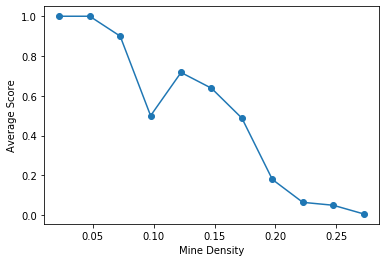

No handles with labels found to put in legend.


In [0]:
# Import the libraries
import matplotlib.pyplot as plt


plt.plot(data["density"]/400, data["mean"]/20/data["density"], marker = 'o', label = "Basic agent")
      
plt.xlabel("Mine Density")
plt.ylabel("Average Score")
plt.show()
plt.legend()
plt.close()


In [0]:
1+2